In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.optimizers import Adam

In [3]:
PATH = 'data'
TEST_RATIO = 0.2
VAL_RATIO = 0.2
IMG_DIM = (28,28,3)

In [4]:
def showimage(title, img):
    cv2.imshow(title, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [5]:
def create_model(no_of_classes):
    no_of_filters = 60
    size_of_filter1 = (5,5)
    size_of_filter2 = (3,3)
    size_of_pool = (2,2)
    no_of_node = 500

    model = Sequential()
    model.add((Conv2D(no_of_filters, size_of_filter1, input_shape=(IMG_DIM[0], IMG_DIM[1], 1),
            activation='relu')))
    model.add((Conv2D(no_of_filters, size_of_filter1, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add((Conv2D(no_of_filters // 2, size_of_filter2, activation='relu')))
    model.add((Conv2D(no_of_filters // 2, size_of_filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_of_node, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(no_of_classes, activation='softmax'))

    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [6]:
folder_list = os.listdir(PATH)
no_of_classes = len(folder_list)
print(f'Total number of classes : {no_of_classes}')
images = []
classid = []

Total number of classes : 10


In [7]:
print('Importing classes')
for dig in range(no_of_classes):
    pic_list_folder = os.listdir(f'{PATH}/{str(dig)}')
    for pic in pic_list_folder:
        curImg = cv2.imread(f'{PATH}/{str(dig)}/{pic}')
        images.append(curImg)
        classid.append(dig)
    print(dig, end=' ')

Importing classes
0 1 2 3 4 5 6 7 8 9 

In [8]:
images = np.array(images)
classid = np.array(classid)

In [9]:
### Splitting the data
X_train, X_test, y_train, y_test = train_test_split(images, classid, test_size=TEST_RATIO)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=VAL_RATIO)

In [10]:
no_of_samples = []
for dig in range(no_of_classes):
    no_of_samples.append(len(np.where(y_train == dig)[0]))

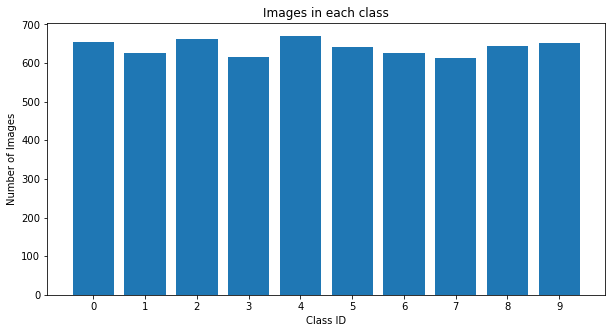

In [11]:
fig = plt.figure(figsize=(10,5))
plt.bar(range(no_of_classes), no_of_samples)
plt.title('Images in each class')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.xticks(range(no_of_classes))
plt.show()

In [12]:
def preprocessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

In [13]:
# img = preprocessing(X_train[30])
# img = cv2.resize(img, (100,100))
# showimage('image', img)

In [14]:
X_train = np.array(list(map(preprocessing, X_train)))
X_test = np.array(list(map(preprocessing, X_test)))
X_validation = np.array(list(map(preprocessing, X_validation)))

In [15]:
# change add a depth of 1 to X.shapes eg : (6400, 28, 28) -> (6400, 28, 28, 1)
X_train = X_train.reshape(*X_train.shape, 1)
X_test = X_test.reshape(*X_test.shape, 1)
X_validation = X_validation.reshape(*X_validation.shape, 1)

In [16]:
dataGen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1,
                                                    zoom_range=0.2, shear_range=0.1, rotation_range=10)

In [17]:
dataGen.fit(X_train)

In [18]:
y_train = to_categorical(y_train, no_of_classes)
y_validation = to_categorical(y_validation, no_of_classes)
y_test = to_categorical(y_test, no_of_classes)

In [19]:
model = create_model(no_of_classes=no_of_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 30)          16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 30)         0         
 2D)                                                    

In [25]:
batch_size = 50
epochs = 10
steps_per_epoch = 128

history = model.fit(dataGen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=steps_per_epoch,
                    epochs=epochs, validation_data=(X_validation, y_validation),
                    shuffle=1)

Epoch 1/10
128/128 [==============================] - 19s 151ms/step - loss: 0.7840 - accuracy: 0.7467 - val_loss: 0.1668 - val_accuracy: 0.9606
Epoch 2/10
128/128 [==============================] - 20s 159ms/step - loss: 0.5278 - accuracy: 0.8336 - val_loss: 0.1123 - val_accuracy: 0.9694
Epoch 3/10
128/128 [==============================] - 20s 155ms/step - loss: 0.4326 - accuracy: 0.8634 - val_loss: 0.1022 - val_accuracy: 0.9706
Epoch 4/10
128/128 [==============================] - 20s 156ms/step - loss: 0.3772 - accuracy: 0.8838 - val_loss: 0.0905 - val_accuracy: 0.9781
Epoch 5/10
128/128 [==============================] - 19s 146ms/step - loss: 0.3458 - accuracy: 0.8948 - val_loss: 0.0951 - val_accuracy: 0.9750
Epoch 6/10
128/128 [==============================] - 17s 132ms/step - loss: 0.2864 - accuracy: 0.9111 - val_loss: 0.0731 - val_accuracy: 0.9806
Epoch 7/10
128/128 [==============================] - 16s 125ms/step - loss: 0.2603 - accuracy: 0.9220 - val_loss: 0.0611 - val_ac

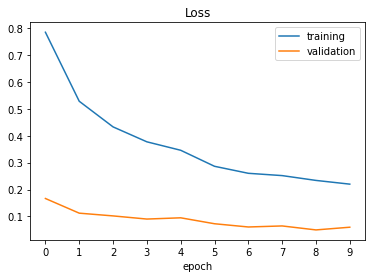

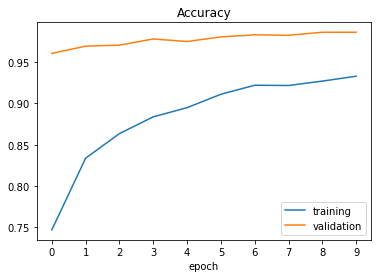

In [26]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['training', 'validation'])
plt.xlabel('epoch')
plt.xticks(range(epochs))
plt.show()
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['training', 'validation'])
plt.xlabel('epoch')
plt.xticks(range(epochs))
plt.show()

In [27]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test score : {score[0]:.5f} and Test accuracy : {score[1]:.5f}')

Test score : 0.07365 and Test accuracy : 0.97850


In [28]:
model.save('./trained_model')

INFO:tensorflow:Assets written to: ./trained_model\assets


INFO:tensorflow:Assets written to: ./trained_model\assets


In [29]:
with open('trained_model.p', 'wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://407dd674-00bc-4d51-998d-4a5496419ac9/assets


INFO:tensorflow:Assets written to: ram://407dd674-00bc-4d51-998d-4a5496419ac9/assets
